Here, you can evaluate the models on the dataset for the training lengths you have run in 2_run_your_benchmark.py.

In [62]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image


Adjust the paths and the settings below.

In [63]:
benchmark_output_folder = "/home/dev/projects/paper/data/outputs/benchmark/"
benchmark_results_folder = benchmark_output_folder + "example_results/"
processed_path = "/home/dev/projects/paper/data/processed/example/"
image_format = "png" #png or pdf
dataset = "example"
forecast_signal = "load"
models = [ "SeasNaive24", "SeasNaive168", "SeasAgg", "XGboost", "LinearRegression", "TimesFM", ] # "AutoETS", "LSTM" "AutoArima",
train_length = 34198

Check which model provides the lowest RMSSE (forecast error metric). The model with the lowest metric is best on the dataset. For live mode use the best model to forecast load.

In [ ]:
result = pd.DataFrame(columns=[f"{m}" for m in models])

for model in models: 
    met = pd.read_parquet(f"{benchmark_output_folder}{dataset}/train_{train_length}/{model}/agg_metrics.parquet")["RMSSE"]
    result[f"{model}"] = met["RMSSE"].round(3)  
result.to_csv(benchmark_results_folder + "agg_train_len_results_rmsse.csv")
result

,SeasNaive24,SeasNaive168,SeasAgg,XGboost,LinearRegression,TimesFM
0,0.751,1.676,1.019,0.522,0.666,1.146


In [65]:
best_model = result.idxmin(axis=1).values[0]
print(f"The best model according to RMSSE is {best_model}.")

The best model according to RMSSE is XGboost.


Plot some forecasts made by the best model.

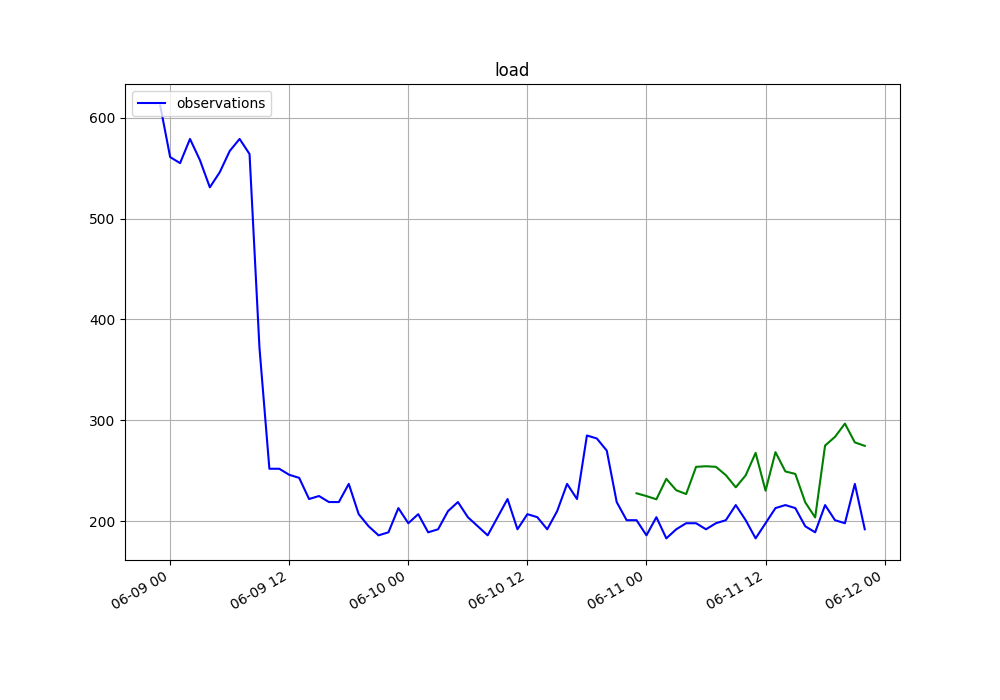

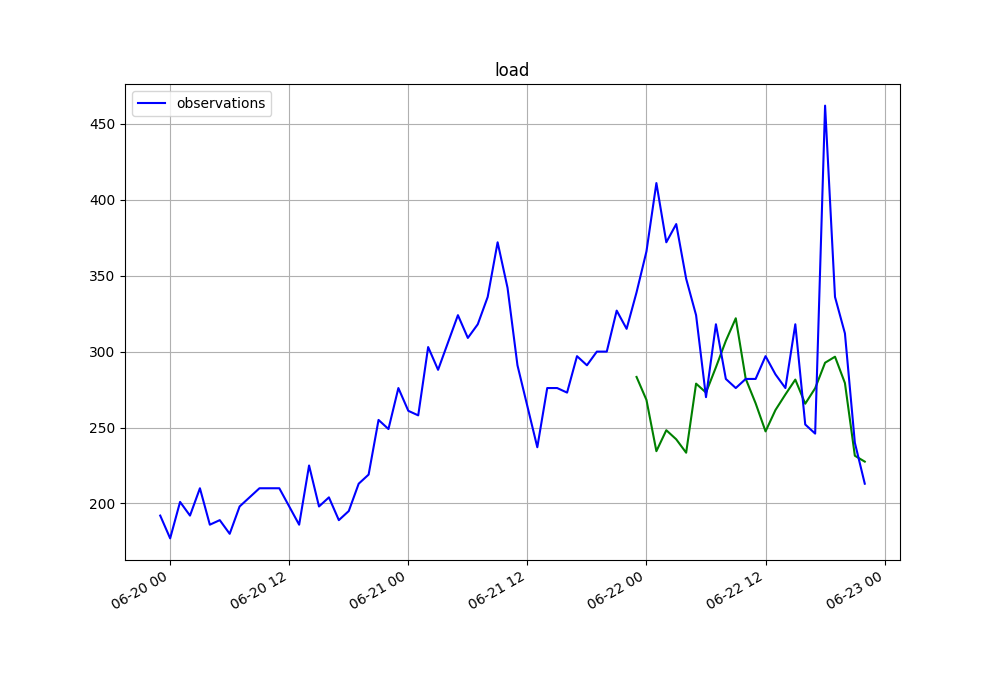

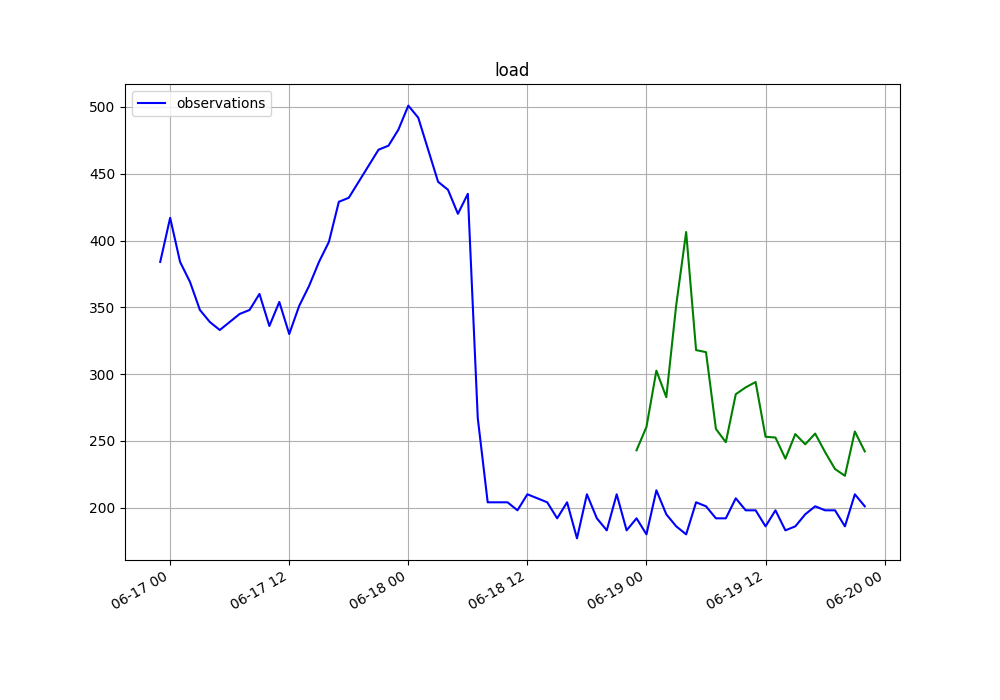

In [66]:
import random
files = os.listdir(f"{benchmark_output_folder}{dataset}/train_{train_length}/{best_model}/")
limit = 3 # how many forecasts you want to display
images = [file for file in files if file.endswith(".png")]
random_files = random.sample(images, 3) 
c=0
for image in random_files:
    c+=1
    if c>limit:break
    display(Image(os.path.join(f"{benchmark_output_folder}{dataset}/train_{train_length}/{best_model}/", image)))

Plot all forecasts of the testset vs. the true test set.

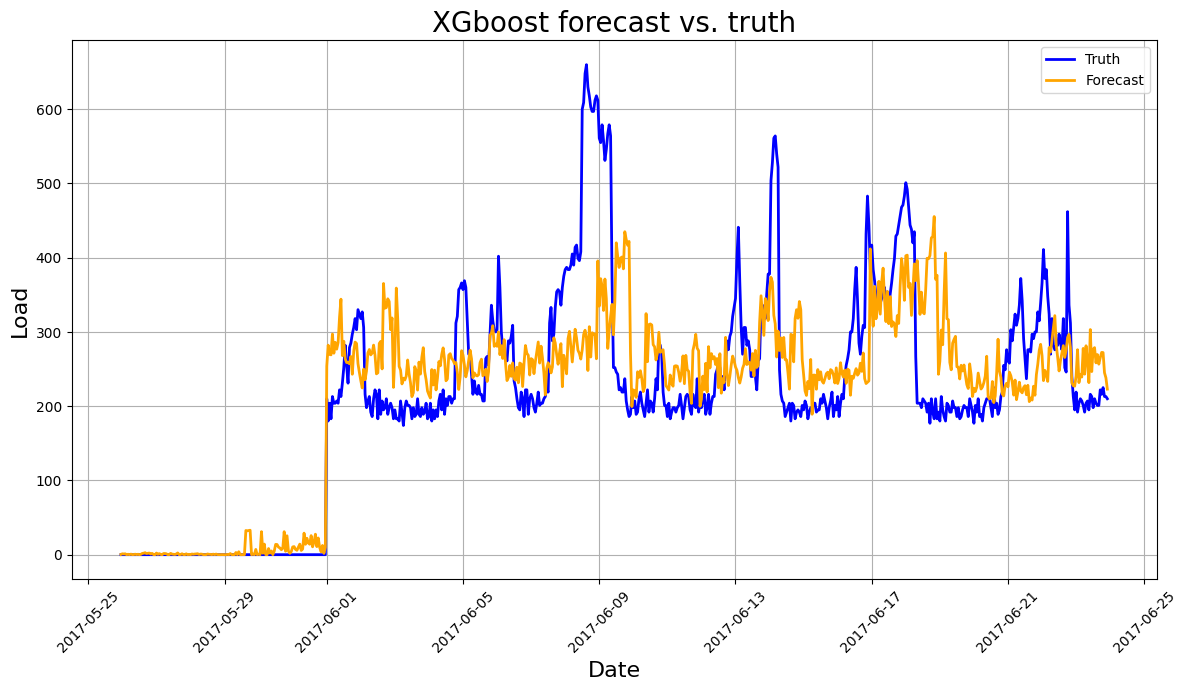

In [67]:
truth = pd.read_parquet(processed_path+ "processed.parquet")

directory = f"{benchmark_output_folder}{dataset}/train_{train_length}/{best_model}/"

single_fcst = []

for filename in os.listdir(directory):

    if filename.endswith('_forecast.parquet'):
        file_path = os.path.join(directory, filename)
        fcst = pd.read_parquet(file_path)
        single_fcst.append(fcst)

all_fcst = pd.concat(single_fcst, ignore_index=True)
all_fcst.drop(columns = ["start_date", "fcst_step"], inplace=True)
all_fcst.rename(columns={"sample_fcst0":"forecast", "fcst_step_date":"date"}, inplace=True)
all_fcst['date'] = all_fcst['date'].dt.tz_localize('UTC')

fcst_vs_truth = all_fcst.merge(truth[["date", "power"]], on="date")
fcst_vs_truth.rename(columns={"power":"truth"}, inplace=True)

import matplotlib.pyplot as plt
import seaborn as sns

fcst_vs_truth['date'] = pd.to_datetime(fcst_vs_truth['date'])

plt.figure(figsize=(14, 7))
sns.lineplot(data=fcst_vs_truth, x='date', y='truth', label='Truth', color='blue', linewidth=2)
sns.lineplot(data=fcst_vs_truth, x='date', y='forecast', label='Forecast', color='orange', linewidth=2)

plt.title(f'{best_model} forecast vs. truth', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Load', fontsize=16)
plt.legend()
plt.xticks(rotation=45)  
plt.grid()
plt.savefig(f'{benchmark_results_folder}{best_model}_forecast_vs_truth.png')  
plt.show()

Plot the forecast error distribution of the best model.

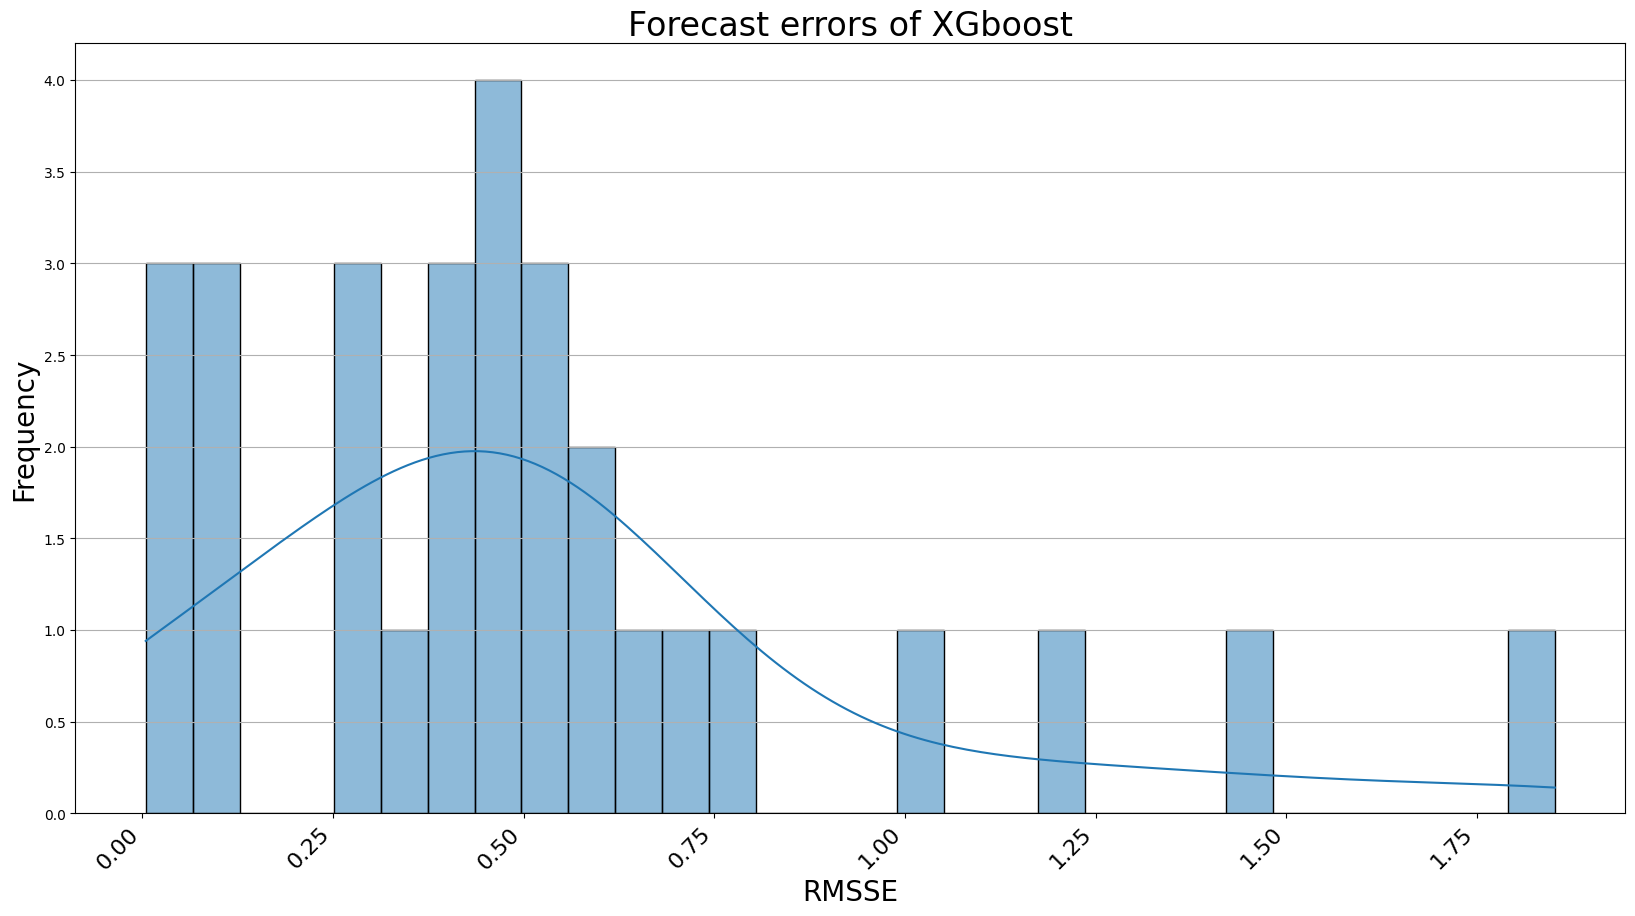

The worst case error is 1.85.
The worst case bias is 87.02.


In [68]:
directory = f"{benchmark_output_folder}{dataset}/train_{train_length}/{best_model}/"

single_metrics = []

for filename in os.listdir(directory):

    if filename.endswith('_metrics.parquet') and filename != 'agg_metrics.parquet':
        file_path = os.path.join(directory, filename)
        met = pd.read_parquet(file_path)
        single_metrics.append(met)

all_metrics = pd.concat(single_metrics, ignore_index=True)[["RMSSE", "bias"]]

plt.figure(figsize=(20, 10))
sns.histplot(all_metrics["RMSSE"], bins=30, kde=True)

plt.xlabel('RMSSE', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

plt.xticks(rotation=45, ha='right', fontsize=16)
plt.title(f'Forecast errors of {best_model}', fontsize=24)

plt.grid(axis='y')
plt.savefig(f'{benchmark_results_folder}{best_model}_rmsse_histogram.png') 
plt.show()

worst_case_error = all_metrics.RMSSE.max().round(2)
worst_case_bias = all_metrics.bias.max().round(2)
print(f"The worst case error is {worst_case_error}.")
print(f"The worst case bias is {worst_case_bias}.")


Now you can use the best model for your data in live mode. For that, continue with the readme in the deployment folder.